In [1]:
#importing packages
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from sklearn.cluster import KMeans
import os
import talib
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import random
import math
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA  # to apply PCA
import pandas_ta as ta
from mrmr import mrmr_classif
from sklearn.preprocessing import Normalizer
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pandas_datareader import data as pdr
import yfinance as yf
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm

In [2]:
resp = requests.get('https://en.wikipedia.org/wiki/S%26P_100')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'wikitable sortable'})
tickers = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    tickers.append(ticker)

tickers = [s.replace('\n', '') for s in tickers]


The following companey is not available any more so I removed it from the tickers list

In [3]:
tickers.remove('BRK.B')

## Download all the price history of the top 100 companies in the US market. I chosed to train the model on the last three years given that data would more consistent than it would be for a larger period of time. 

In [4]:
yf.pdr_override()
data=pd.DataFrame()
i=1
for ticker in tickers:#len(tickers)):
    print(ticker)
    data_s=pdr.get_data_yahoo(ticker, start='2020-1-1', end='2023-12-31')
    data_s["Ticker"]=ticker
    data_s["Asset_ID"]=i
    data=pd.concat([data, data_s])
    i+=1

AAPL
[*********************100%***********************]  1 of 1 completed
ABBV
[*********************100%***********************]  1 of 1 completed
ABT
[*********************100%***********************]  1 of 1 completed
ACN
[*********************100%***********************]  1 of 1 completed
ADBE
[*********************100%***********************]  1 of 1 completed
AIG
[*********************100%***********************]  1 of 1 completed
AMD
[*********************100%***********************]  1 of 1 completed
AMGN
[*********************100%***********************]  1 of 1 completed
AMT
[*********************100%***********************]  1 of 1 completed
AMZN
[*********************100%***********************]  1 of 1 completed
AVGO
[*********************100%***********************]  1 of 1 completed
AXP
[*********************100%***********************]  1 of 1 completed
BA
[*********************100%***********************]  1 of 1 completed
BAC
[*********************100%****************

In [5]:
data

,Open,High,Low,Close,Adj Close,Volume,Ticker,Asset_ID
Date,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.347923,135480400,AAPL,1
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.634850,146322800,AAPL,1
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.213615,118387200,AAPL,1
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.869286,108872000,AAPL,1
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.041489,132079200,AAPL,1
...,...,...,...,...,...,...,...,...
2023-06-16,106.360001,106.769997,104.959999,105.129997,105.129997,43124000,XOM,100
2023-06-20,104.680000,104.769997,102.120003,102.720001,102.720001,17514100,XOM,100
2023-06-21,102.500000,104.629997,102.330002,103.870003,103.870003,13285700,XOM,100


# Data clustering

I will perform usupervised clustring here, to see if there is any correlation in the general behavor os the stocks.
For that I will evaluate the daily stock movementes defined as the difference between the opening price and closing price of each stock.

In [6]:
data["movement"]=data["Open"]-data["Close"]

In [7]:
dd=data[["Ticker","movement"]]

In [8]:
dd

,Ticker,movement
Date,,
2020-01-02,AAPL,-1.027504
2020-01-03,AAPL,-0.070000
2020-01-06,AAPL,-1.502495
2020-01-07,AAPL,0.362495
2020-01-08,AAPL,-1.507500
...,...,...
2023-06-16,XOM,1.230003
2023-06-20,XOM,1.959999
2023-06-21,XOM,-1.370003


rewrite the data frame such that the rows represent companies, and the columns represent the movemnts

In [9]:
dictionary={}
for ticker in tickers:
    ss_t=dd[dd["Ticker"]==ticker].movement.values
    dictionary[ticker]=ss_t
df=pd.DataFrame(dictionary).T

In [10]:
df

,0,1,2,3,4,5,6,7,8,9,...,865,866,867,868,869,870,871,872,873,874
AAPL,-1.027504,-0.070000,-1.502495,0.362495,-1.507500,-0.597504,0.067505,-1.329994,1.005005,0.127502,...,0.539993,-2.519989,-0.509995,-0.580002,-2.049988,1.809998,-0.599991,0.939987,-3.259995,-1.129990
ABBV,-0.470001,-0.529999,-1.180000,0.040001,-0.369995,-0.199997,1.170006,0.980003,-1.099998,-1.080002,...,-0.619995,1.850006,-0.800003,2.580002,0.860001,-1.940002,-0.720001,-0.110001,-0.260010,1.380005
ABT,-0.889999,-0.139999,-0.719994,-0.090004,0.029999,-0.139999,1.430000,0.379997,-1.610001,-1.269997,...,-0.720001,0.439995,-0.370003,0.059998,-1.759995,-0.759995,-1.500000,0.370003,-1.559998,0.149994
ACN,0.710007,-1.300003,-0.159988,-0.729996,-0.330002,-0.649994,-0.730011,-2.099991,1.820007,0.740005,...,0.410004,-3.650024,0.160004,0.970001,-4.589996,6.380005,-0.139984,3.289978,-9.040009,1.589996
ADBE,-4.429993,-2.639984,-5.419983,0.759979,-4.059998,-0.309998,2.239990,-4.089996,2.380005,3.480011,...,2.910004,-10.920013,10.720001,-3.380005,-15.440002,23.049988,-0.229980,14.519989,-3.459991,-11.769989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VZ,0.330002,0.189999,-0.160000,0.500000,-0.040001,0.040001,0.029999,-0.130001,-0.040001,0.150002,...,-0.010002,0.049999,0.020000,-0.099998,-0.680000,0.060001,0.270000,-0.130001,-0.029999,0.440002
WBA,0.199997,-0.540001,-0.549999,-0.070000,0.219997,1.110001,0.619999,0.139999,-0.579998,0.110001,...,0.360001,-0.080000,-0.160000,0.690001,-0.410000,-0.839998,0.230000,0.760000,-0.240000,0.330000
WFC,0.099998,-0.309998,-0.359997,0.389999,0.020000,0.470001,0.290001,0.389999,0.930000,0.510002,...,0.200001,0.279999,-0.970001,0.669998,-0.540001,0.400002,0.230000,0.199997,0.489998,-0.080002
WMT,-0.080002,0.379997,-0.250000,0.700005,0.139999,-1.209999,0.860001,0.500000,-0.709999,-0.650002,...,-0.929993,-0.670013,-0.779999,-0.959991,-0.729996,2.550003,0.539993,-0.250000,-0.770004,0.419998


Generally speacking, prices of stocks of companies within same sector tend to behave similarly. They rise and fall nearly simultanously. So we expect, KMeans algorthm to be able to cluster stocks of same sectors or close ones together. However, the movements of different companies have different scales due to the diffences in the prices of each stock. ake for example, NVIDIA company(NVDA) and AMD electronics (AMD). Both companies are working in semiconductor technolgy and we expect both companies to be in the same cluster. However, they have different price movement scale due to price difffrences. NVDA stock is around 430 USD and AMD is arround 130 USD. Thius the movemnts need to rescaled.

<Axes: >

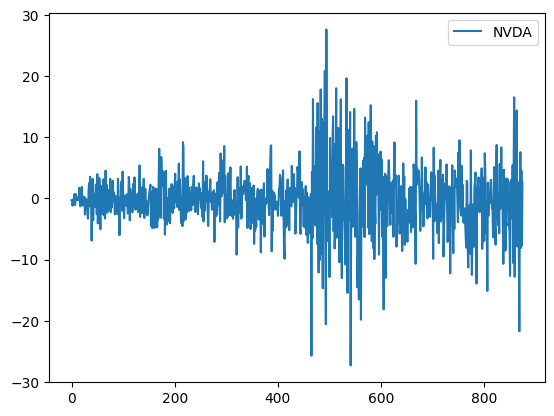

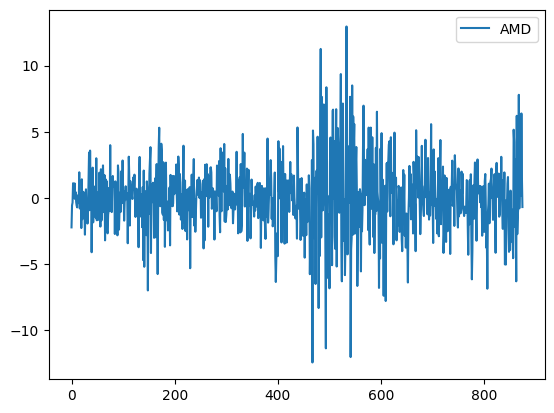

In [11]:
df[df.index=="NVDA"].T.plot()
df[df.index=="AMD"].T.plot()

So to rescale the price movement, I use the standard sklearn Normalizer function

In [12]:
normalizer = Normalizer()
X=Normalizer().fit_transform(df.values)

In [13]:
n_clusters=12
kmeans = KMeans(n_clusters=n_clusters,random_state=12)
kmeans.fit(X)
clusters=kmeans.predict(X)

In [14]:
df["cluster"]=clusters

In [15]:
for i in range(n_clusters):
    print(i, list(df[df["cluster"]==i].index))

0 ['BLK', 'CHTR', 'FDX', 'HD', 'LIN', 'LOW', 'NKE', 'TGT', 'UNP', 'UPS']
1 ['AXP', 'BAC', 'BK', 'C', 'COF', 'GS', 'JPM', 'MS', 'USB', 'WFC']
2 ['CMCSA', 'COST', 'CSCO', 'CVS', 'GILD', 'IBM', 'MMM', 'ORCL', 'T', 'WBA']
3 ['ABBV', 'BMY', 'LLY', 'MRK', 'PFE']
4 ['AAPL', 'ACN', 'ADBE', 'AMZN', 'CRM', 'GOOG', 'GOOGL', 'META', 'MSFT', 'NFLX']
5 ['COP', 'CVX', 'XOM']
6 ['AMT', 'DUK', 'EXC', 'NEE', 'SO']
7 ['ABT', 'DHR', 'TMO']
8 ['BKNG', 'DIS', 'MA', 'MCD', 'MDT', 'SBUX', 'TMUS', 'V']
9 ['AIG', 'BA', 'CAT', 'DOW', 'EMR', 'F', 'GD', 'GE', 'GM', 'HON', 'MET', 'RTX', 'SCHW', 'SPG']
10 ['AMD', 'AVGO', 'INTC', 'NVDA', 'PYPL', 'QCOM', 'TSLA', 'TXN']
11 ['AMGN', 'CL', 'JNJ', 'KHC', 'KO', 'LMT', 'MDLZ', 'MO', 'PEP', 'PG', 'PM', 'UNH', 'VZ', 'WMT']


Note that cluster 10 consists of Technolgy sector companies, cluster 5 all oil and energy companies etc..

# Data feturizing using technical analysis indicators

I will be using ta-lib library to calculate various technical analysis indicators

In [16]:
def volume(df):
    for i in df["Asset_ID"].unique():
        high=df[df["Asset_ID"]==i]["High"]
        low=df[df["Asset_ID"]==i]["Low"]
        close=df[df["Asset_ID"]==i]["Close"]
        volume=df[df["Asset_ID"]==i]["Volume"]
        #chakin oscillator > 0 buy, < 0 sell
        df["AD"]= talib.AD(high, low, close, volume)
        
        df["ADOSC"]= talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
        df["OBV"]= talib.OBV(close, volume)
    return df
def momentum_with_state(df,window=10,state='Close'):
    for i in df["Asset_ID"].unique():
        df["CMO_"+str(window)+state]= talib.CMO(df[df["Asset_ID"]==i][state], timeperiod=window)       
        df["MOM"+str(window)]= talib.MOM(df[df["Asset_ID"]==i][state], timeperiod=window)
        df["ROC"+str(window)]= talib.ROC(df[df["Asset_ID"]==i][state],timeperiod=window)
        df["ROCP_"+str(window)]= talib.ROCP(df[df["Asset_ID"]==i][state],timeperiod=window)
        df["ROCR_"+str(window)]= talib.ROCR(df[df["Asset_ID"]==i][state],timeperiod=window)
        df["ROCR100_"+str(window)]= talib.ROCR100(df[df["Asset_ID"]==i][state],timeperiod=window)
        df["RSI"+str(window)]= talib.RSI(df[df["Asset_ID"]==i][state],timeperiod=window)
        df["TRIX_"+str(window)]= talib.TRIX(df[df["Asset_ID"]==i][state],timeperiod=window)
        ###stats
        df["LINEARREG"+state+str(window)]= talib.LINEARREG(df[df["Asset_ID"]==i][state], timeperiod=window)
        df["LINEARREG_INTERCEPT"+state+str(window)]= talib.LINEARREG_INTERCEPT(df[df["Asset_ID"]==i][state], timeperiod=window)
        df["LINEARREG_SLOPE"+state+str(window)]= talib.LINEARREG_SLOPE(df[df["Asset_ID"]==i][state], timeperiod=window)
        df["STDDEV"+state+str(window)]= talib.STDDEV(df[df["Asset_ID"]==i][state], timeperiod=window, nbdev=1)
        df["VAR"+state+str(window)]= talib.VAR(df[df["Asset_ID"]==i][state], timeperiod=window, nbdev=1)
        df["TSF"+state+str(window)]= talib.TSF(df[df["Asset_ID"]==i][state], timeperiod=window)
    return df

def momentum(df,window=10):
    for i in df["Asset_ID"].unique():
        highs=df[df["Asset_ID"]==i]["High"]
        lows=df[df["Asset_ID"]==i]["Low"]
        closes=df[df["Asset_ID"]==i]["Close"]
        volume=df[df["Asset_ID"]==i]["Volume"]
        df["ADX_"+str(window)]=talib.ADX(highs,lows,closes,timeperiod=5)
        df["ADXR_"+str(window)]=talib.ADXR(highs,lows,closes,timeperiod=5)
        df["AROON_"+str(window)+"_aroondown"],df["AROON_"+str(window)+"_aroonup"]= talib.AROON(highs, lows, timeperiod=5)
        df["AROONOSC_"+str(window)]= talib.AROONOSC(highs, lows, timeperiod=5)  
        df["CCI_"+str(window)]= talib.CCI(highs, lows, closes, timeperiod=5)
        df["DX_"+str(window)]= talib.DX(highs, lows, closes, timeperiod=5)
        df["MFI_"+str(window)]= talib.MFI(highs, lows, closes, volume, timeperiod=8)        
        df["MINUS_DI"+str(window)]= talib.MINUS_DI(highs, lows, closes, timeperiod=20)
        df["MINUS_DM"+str(window)]= talib.MINUS_DM(highs, lows, timeperiod=20)
        df["PLUS_DI_"+str(window)]= talib.PLUS_DI(highs, lows, closes, timeperiod=20)
        df["PLUS_DM_"+str(window)]= talib.PLUS_DM(highs, lows, timeperiod=10)
        df["ULTOSC"+str(window)]= talib.ULTOSC(highs, lows, closes, timeperiod1=7, timeperiod2=14, timeperiod3=28)
        df["WILLR"+str(window)]= talib.WILLR(highs, lows, closes, timeperiod=7)
        ##state
        df["BETA"+str(window)]= talib.BETA(highs, lows, timeperiod=13)
        df["CORREL"+str(window)]= talib.CORREL(highs, lows, timeperiod=8)
        return df
def volatility(df,window=14):
    for i in df["Asset_ID"].unique():
        high=df[df["Asset_ID"]==i]["High"]
        low=df[df["Asset_ID"]==i]["Low"]
        close=df[df["Asset_ID"]==i]["Close"]
        df["ATR"]= talib.ATR(high, low, close, timeperiod=window)
        df["NATR"]= talib.NATR(high, low, close, timeperiod=window)
        df["TRANGE"]= talib.TRANGE(high, low, close)
    return df
def momentum_no_window(df):
    for i in df["Asset_ID"].unique():
        opens=df[df["Asset_ID"]==i]["Open"]
        highs=df[df["Asset_ID"]==i]["High"]
        lows=df[df["Asset_ID"]==i]["Low"]
        closes=df[df["Asset_ID"]==i]["Close"]
        df["BOP"]= talib.BOP(opens, highs, lows, closes)
        df["STOCH"+"_fast"], df["STOCH"+"_slow"] = talib.STOCH(highs, lows, closes, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)  
        df["STOCHF"+"_fast"], df["STOCHF"+"_slow"] = talib.STOCHF(highs, lows, closes, fastk_period=5, fastd_period=3, fastd_matype=0)    
    return df    
    
def momentum_with_state_no_window(df,state='Close'):
    for i in df["Asset_ID"].unique():
        df["MACD"], df["MACD"+"_signal]"],df["MACD"+"_hist]"]  = talib.MACD(df[df["Asset_ID"]==i][state], fastperiod=12, slowperiod=26, signalperiod=9)
        df["MACDEXT"], df["MACDEXT"+"_signal]"],df["MACDEXT"+"_hist]"]  = talib.MACDEXT(df[df["Asset_ID"]==i][state],fastperiod=12, fastmatype=0, slowperiod=26, slowmatype=0, signalperiod=9, signalmatype=0)
        df["MACDFIX"], df["MACDFIX"+"_signal]"],df["MACDFIX"+"_hist]"]  = talib.MACDFIX(df[df["Asset_ID"]==i][state],signalperiod=9)
        df["PPO"]= talib.PPO(df[df["Asset_ID"]==i][state], fastperiod=12, slowperiod=26, matype=0)
        df["APO"]=talib.APO(df[df["Asset_ID"]==i][state],fastperiod=12, slowperiod=26, matype=0)
        df["STOCHRSI"+"_fast"], df["STOCHRSI"+"_slow"] = talib.STOCHRSI(df[df["Asset_ID"]==i][state], timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    return df
def price(df):
    for i in df["Asset_ID"].unique():
        opens=df[df["Asset_ID"]==i]["Open"]
        high=df[df["Asset_ID"]==i]["High"]
        low=df[df["Asset_ID"]==i]["Low"]
        close=df[df["Asset_ID"]==i]["Close"]
        df["AVGPRICE"]= talib.AVGPRICE(opens, high, low, close)
        df["MEDPRICE"]= talib.MEDPRICE(high, low)
        #df["TYPRICE"]= talib.TYPRICE(high, low, close)
        df["WCLPRICE"]= talib.WCLPRICE(high, low, close)
    return df

def maths(df,window=30):
    for i in df["Asset_ID"].unique():
        opens=df[df["Asset_ID"]==i]["Open"]
        high=df[df["Asset_ID"]==i]["High"]
        low=df[df["Asset_ID"]==i]["Low"]
        close=df[df["Asset_ID"]==i]["Close"]
        df["MAX"]= talib.MAX(close, timeperiod=window)
        df["MAXINDEX"]= talib.MAXINDEX(close, timeperiod=window)
        df["MIN"]= talib.MIN(close, timeperiod=window)
        df["MINDEX"],df["MAXDEX"]= talib.MINMAXINDEX(close, timeperiod=window)
        df["SUM"]= talib.SUM(close, timeperiod=window)
    return df
def maths_no_window(df):
    for i in df["Asset_ID"].unique():
        opens=df[df["Asset_ID"]==i]["Open"]
        highs=df[df["Asset_ID"]==i]["High"]
        lows=df[df["Asset_ID"]==i]["Low"]
        closes=df[df["Asset_ID"]==i]["Close"]
        df["ADD_H_L"]= talib.ADD(highs, lows)
        df["DIV_H_L"]= talib.DIV(highs, lows)
        df["MULT_H_L"]= talib.MULT(highs, lows)
        df["SUB_H_L"]= talib.SUB(highs, lows)
        df["ADD_H_L"]= talib.ADD(opens, closes)
        df["DIV_H_L"]= talib.DIV(opens, closes)
        df["MULT_H_L"]= talib.MULT(opens, closes)
        df["SUB_H_L"]= talib.SUB(opens, closes)
    return df
def overlap(df,window=10,state="Close"):
    for i in df["Asset_ID"].unique():
        #print("OK")
        df["BB_"+str(window)+"_"+state+"upperband"], df["BB_"+str(window)+"_"+state+"middleband"], df["BB_"+str(window)+state+"lowerband"] = talib.BBANDS(df[df["Asset_ID"]==i][state], timeperiod=window)
        df["DEMA_"+str(window)+"_"+state] = talib.DEMA(df[df["Asset_ID"]==i][state], timeperiod=window)
        #df["EMA_"+str(window)+"_"+state] = talib.EMA(df[df["Asset_ID"]==i][state], timeperiod=window)
        #df["ht_"+"_"+state] = talib.HT_TRENDLINE(df[df["Asset_ID"]==i][state])
        df["KAMA_"+str(window)+"_"+state]=talib.KAMA(df[df["Asset_ID"]==i][state],timeperiod=window)
        #df["SMA_"+str(window)+"_"+state]=talib.SMA(df[df["Asset_ID"]==i][state],timeperiod=window)
        df["MA_"+str(window)+"_"+state]=talib.MA(df[df["Asset_ID"]==i][state],timeperiod=window)
        #df["MAMA_"+state+"_mama"],df["MAMA_"+state+"_fama"]=talib.MAMA(df[df["Asset_ID"]==i][state],fastlimit=0, slowlimit=0)
        #df["MAVP_"+state]=talib.MAVP(df[df["Asset_ID"]==i][state],np.arange(30), minperiod=2, maxperiod=30, matype=0)
        df["MDPT_"+str(window)+"_"+state]=talib.MIDPOINT(df[df["Asset_ID"]==i][state],timeperiod=window)
        df["MDPRICE_"+str(window)]=talib.MIDPRICE(df[df["Asset_ID"]==i]["High"],df[df["Asset_ID"]==i]["Low"],timeperiod=window)
        df["SAR_"+"_"+state]=talib.SAR(df[df["Asset_ID"]==i]["High"],df[df["Asset_ID"]==i]["Low"],acceleration=0, maximum=0)                       
        df["SAR_"+"_"+state]=talib.SAREXT(df[df["Asset_ID"]==i]["High"],df[df["Asset_ID"]==i]["Low"],startvalue=0, 
                                     offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, 
                                     accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, 
                                     accelerationmaxshort=0)      
        df["T3_"+str(window)+"_"+state]=talib.T3(df[df["Asset_ID"]==i][state],timeperiod=window, vfactor=0)
        df["TEMA_"+str(window)+"_"+state]=talib.SMA(df[df["Asset_ID"]==i][state],timeperiod=window)
        df["TRIMA_"+str(window)+"_"+state]=talib.TRIMA(df[df["Asset_ID"]==i][state],timeperiod=window)
        df["WMA_"+str(window)+"_"+state]=talib.WMA(df[df["Asset_ID"]==i][state],timeperiod=window)
    return df

In [17]:
#generate features

data=volume(data)
data=momentum_with_state(data)
data=momentum(data)
data=volatility(data)
data=momentum_no_window(data)
data=momentum_with_state_no_window(data)
data=price(data)
data=maths(data)
data=maths_no_window(data)
data=overlap(data)
data=overlap(data,window=10,state="Volume")

In [18]:
data

,Open,High,Low,Close,Adj Close,Volume,Ticker,Asset_ID,movement,AD,...,BB_10Volumelowerband,DEMA_10_Volume,KAMA_10_Volume,MA_10_Volume,MDPT_10_Volume,SAR__Volume,T3_10_Volume,TEMA_10_Volume,TRIMA_10_Volume,WMA_10_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-02,74.059998,75.150002,73.797501,75.087502,73.347923,135480400,AAPL,1,-1.027504,8.623811e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,74.287498,75.144997,74.125000,74.357498,72.634850,146322800,AAPL,1,-0.070000,-3.877562e+06,...,NaN,NaN,NaN,NaN,NaN,-71.370003,NaN,NaN,NaN,NaN
2020-01-06,73.447502,74.989998,73.187500,74.949997,73.213615,118387200,AAPL,1,-1.502495,-1.211790e+06,...,NaN,NaN,NaN,NaN,NaN,-71.370003,NaN,NaN,NaN,NaN
2020-01-07,74.959999,75.224998,74.370003,74.597504,72.869286,108872000,AAPL,1,0.362495,8.256864e+06,...,NaN,NaN,NaN,NaN,NaN,-71.370003,NaN,NaN,NaN,NaN
2020-01-08,74.290001,76.110001,74.290001,75.797501,74.041489,132079200,AAPL,1,-1.507500,-5.258803e+06,...,NaN,NaN,NaN,NaN,NaN,-71.370003,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-16,106.360001,106.769997,104.959999,105.129997,105.129997,43124000,XOM,100,1.230003,-2.445954e+08,...,-1.090143e+06,2.439577e+07,2.344962e+07,16825520.0,26876000.0,30.110001,1.451634e+07,16825520.0,1.495353e+07,1.978441e+07
2023-06-20,104.680000,104.769997,102.120003,102.720001,102.720001,17514100,XOM,100,1.959999,-2.541786e+08,...,8.139598e+04,2.279940e+07,2.335563e+07,17514130.0,27666900.0,30.110001,1.479073e+07,17514130.0,1.636653e+07,1.990960e+07
2023-06-21,102.500000,104.629997,102.330002,103.870003,103.870003,13285700,XOM,100,-1.370003,-2.496729e+08,...,3.083900e+05,2.015822e+07,2.330088e+07,17621720.0,27687800.0,30.110001,1.509038e+07,17621720.0,1.765513e+07,1.914080e+07


Calculate the weekly price movement defind as differnce between the highest price in two successive weeks
and assign a value of 1 if the direction of the price is up or zero if it is down

In [19]:
def target(x):
    if x<0:
        return 0
    else:
        return  1

for i in data["Asset_ID"].unique():
    data["High_W+1"] = data[data["Asset_ID"]==i]['High'].shift(-5)
    data["weekly_returns"] = data[data["Asset_ID"]==i]["High_W+1"]-data[data["Asset_ID"]==i]['High']
    data["direction_W"]=data[data["Asset_ID"]==i]["weekly_returns"].apply(target)

In [20]:
data=data.dropna()

In [21]:
data

,Open,High,Low,Close,Adj Close,Volume,Ticker,Asset_ID,movement,AD,...,MA_10_Volume,MDPT_10_Volume,SAR__Volume,T3_10_Volume,TEMA_10_Volume,TRIMA_10_Volume,WMA_10_Volume,High_W+1,weekly_returns,direction_W
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-20,61.794998,62.957500,57.000000,57.310001,56.115154,401693200,AAPL,1,4.484997,-3.166182e+08,...,60105760.0,60547950.0,-71.370003,4.418674e+07,60105760.0,5.863383e+07,5.884423e+07,37.680000,2.500000,1
2020-03-23,57.020000,57.125000,53.152500,56.092499,54.923027,336752800,AAPL,1,0.927502,-3.146392e+08,...,58511380.0,60547950.0,-71.370003,4.560329e+07,58511380.0,5.687367e+07,5.827091e+07,38.150002,5.450001,1
2020-03-24,59.090000,61.922501,58.575001,61.720001,60.433220,287531200,AAPL,1,-2.630001,-2.845923e+08,...,58650350.0,60547950.0,-71.370003,4.695549e+07,58650350.0,5.660027e+07,5.887532e+07,39.450001,3.280003,1
2020-03-25,62.687500,64.562500,61.075001,61.380001,60.100300,303602000,AAPL,1,1.307499,-2.711459e+08,...,59112510.0,60547950.0,-71.370003,4.821260e+07,59112510.0,5.705396e+07,5.850393e+07,38.700001,0.110001,1
2020-03-26,61.630001,64.669998,61.590000,64.610001,63.262966,252087200,AAPL,1,-2.980000,-2.487720e+08,...,57212180.0,60547950.0,-71.370003,4.929912e+07,57212180.0,5.734963e+07,5.625111e+07,41.959999,2.399998,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-09,108.459999,108.610001,107.160004,107.389999,107.389999,12251600,XOM,100,1.070000,-1.834255e+08,...,14153020.0,17777050.0,30.110001,1.452971e+07,14153020.0,1.417100e+07,1.377104e+07,106.769997,-1.840004,0
2023-06-12,105.809998,107.059998,105.559998,106.419998,106.419998,14112000,XOM,100,-0.610001,-1.813557e+08,...,14327190.0,17777050.0,30.110001,1.447255e+07,14327190.0,1.387837e+07,1.376358e+07,104.769997,-2.290001,0
2023-06-13,107.379997,108.339996,106.279999,106.440002,106.440002,13533800,XOM,100,0.939995,-1.927871e+08,...,14486770.0,17777050.0,30.110001,1.441193e+07,14486770.0,1.368794e+07,1.361933e+07,104.629997,-3.709999,0


remove uneeded redundant columns

In [22]:
data=data.drop(columns=['Open','High','Adj Close','Low','High_W+1','weekly_returns']).copy()

In [23]:
data

,Close,Volume,Ticker,Asset_ID,movement,AD,ADOSC,OBV,CMO_10Close,MOM10,...,DEMA_10_Volume,KAMA_10_Volume,MA_10_Volume,MDPT_10_Volume,SAR__Volume,T3_10_Volume,TEMA_10_Volume,TRIMA_10_Volume,WMA_10_Volume,direction_W
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-20,57.310001,401693200,AAPL,1,4.484997,-3.166182e+08,-2.459453e+07,-631019600.0,-50.479658,-14.949997,...,6.297293e+07,3.800217e+07,60105760.0,60547950.0,-71.370003,4.418674e+07,60105760.0,5.863383e+07,5.884423e+07,1
2020-03-23,56.092499,336752800,AAPL,1,0.927502,-3.146392e+08,-2.174550e+07,-687972100.0,-53.447898,-10.410000,...,6.188238e+07,3.831177e+07,58511380.0,60547950.0,-71.370003,4.560329e+07,58511380.0,5.687367e+07,5.827091e+07,1
2020-03-24,61.720001,287531200,AAPL,1,-2.630001,-2.845923e+08,-9.042762e+06,-626136500.0,-27.237652,-7.970001,...,6.260362e+07,3.842811e+07,58650350.0,60547950.0,-71.370003,4.695549e+07,58650350.0,5.660027e+07,5.887532e+07,1
2020-03-25,61.380001,303602000,AAPL,1,1.307499,-2.711459e+08,1.254290e+06,-569528800.0,-16.946707,-4.689999,...,6.133282e+07,3.855722e+07,59112510.0,60547950.0,-71.370003,4.821260e+07,59112510.0,5.705396e+07,5.850393e+07,1
2020-03-26,64.610001,252087200,AAPL,1,-2.980000,-2.487720e+08,1.247165e+07,-522806800.0,-8.856316,1.639999,...,5.705791e+07,3.873614e+07,57212180.0,60547950.0,-71.370003,4.929912e+07,57212180.0,5.734963e+07,5.625111e+07,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-09,107.389999,12251600,XOM,100,1.070000,-1.834255e+08,5.010521e+06,-52199600.0,7.123879,1.729996,...,1.329889e+07,1.873156e+07,14153020.0,17777050.0,30.110001,1.452971e+07,14153020.0,1.417100e+07,1.377104e+07,0
2023-06-12,106.419998,14112000,XOM,100,-0.610001,-1.813557e+08,4.458535e+06,-66311600.0,-1.310183,1.449997,...,1.349356e+07,1.869346e+07,14327190.0,17777050.0,30.110001,1.447255e+07,14327190.0,1.387837e+07,1.376358e+07,0
2023-06-13,106.440002,13533800,XOM,100,0.939995,-1.927871e+08,1.901341e+05,-52777800.0,-1.127740,2.400002,...,1.345317e+07,1.865302e+07,14486770.0,17777050.0,30.110001,1.441193e+07,14486770.0,1.368794e+07,1.361933e+07,0


# Constructing the model

Out of the 100 companies, I will be using apple stock to build the model and check its validity

In [24]:
df=data[data["Ticker"]=="AAPL"].copy()

In [25]:
def normalize_data(data):
    for column in data.columns:
        min_value = min(data[column])
        max_value = max(data[column])
        normalized_data = [2 * (x - min_value) / (max_value - min_value) - 1 for x in data[column]]
        data[column]=normalized_data
    return data

scale the data

In [26]:
y=df["direction_W"].values
df_scaled=normalize_data(df.drop(columns=["Ticker","Asset_ID","direction_W"]))

In [27]:
df_scaled

,Close,Volume,movement,AD,ADOSC,OBV,CMO_10Close,MOM10,ROC10,ROCP_10,...,BB_10Volumelowerband,DEMA_10_Volume,KAMA_10_Volume,MA_10_Volume,MDPT_10_Volume,SAR__Volume,T3_10_Volume,TEMA_10_Volume,TRIMA_10_Volume,WMA_10_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-20,-0.981257,1.000000,0.698955,0.378688,-0.718406,-0.072484,-0.809020,-0.744374,-1.000000,-1.000000,...,0.964772,1.000000,0.788963,1.000000,1.000000,-1.0,0.594034,1.000000,1.000000,0.998662
2020-03-23,-1.000000,0.645616,0.286253,0.384379,-0.657671,-0.151893,-0.852223,-0.482401,-0.784114,-0.784114,...,0.959637,0.958024,0.816513,0.932770,1.000000,-1.0,0.669710,0.932770,0.924142,0.973982
2020-03-24,-0.913368,0.377010,-0.126450,0.470795,-0.386873,-0.065676,-0.470731,-0.341604,-0.567259,-0.567259,...,0.963140,0.985785,0.826865,0.938630,1.000000,-1.0,0.741947,0.938630,0.912359,1.000000
2020-03-25,-0.918602,0.464710,0.330336,0.509468,-0.167360,0.013252,-0.320946,-0.152337,-0.327778,-0.327778,...,1.000000,0.936871,0.838354,0.958118,1.000000,-1.0,0.809104,0.958118,0.931912,0.984012
2020-03-26,-0.868878,0.183590,-0.167053,0.573816,0.071772,0.078396,-0.203189,0.212926,0.191405,0.191405,...,0.887074,0.772327,0.854275,0.877986,1.000000,-1.0,0.867148,0.877986,0.944655,0.887034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-09,0.922259,-0.925376,0.241299,0.761756,-0.087284,0.734562,0.029403,0.218119,0.098994,0.098994,...,-0.317492,-0.911984,-0.925845,-0.937689,-0.793034,1.0,-0.990305,-0.937689,-0.916225,-0.941633
2023-06-12,0.965824,-0.895885,-0.113688,0.767708,-0.099052,0.714885,-0.093355,0.201962,0.090465,0.090465,...,-0.305651,-0.904492,-0.929236,-0.930344,-0.793034,1.0,-0.993358,-0.930344,-0.928836,-0.941954
2023-06-13,0.958435,-0.892315,0.119490,0.734831,-0.190046,0.733755,-0.090700,0.256780,0.121299,0.121299,...,-0.292201,-0.906046,-0.932835,-0.923615,-0.793034,1.0,-0.996597,-0.923615,-0.937043,-0.948164


# lightGBM method

In [28]:
def models(df,y):
    X=df.values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a LightGBM dataset for training


    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)


    # Set the parameters for the LightGBM classifier
    params={'bagging_fraction': 0.8,
     'bagging_freq': 5,
     'boosting_type': 'gbdt',
     'feature_fraction': 0.8,
     'num_leaves': 15,
     'metric': 'auc',
     'num_iterations':100,
     'random_state': 47,
     'bagging_seed': 11,
     'max_depth': -1,
     'objective': 'binary',
     'learning_rate': 0.1 }

    # Train the LightGBM classifier
    #model = lgb.train(params, train_data, num_boost_round=100)
    model = lgb.train(params,train_data,valid_sets=test_data,num_boost_round=100)
    y_pred = model.predict(X_test)
    y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]
    # Evaluate the model's accuracy
    accuracy = accuracy_score(y_test, y_pred_binary)
    print("Accuracy:", accuracy)
    return accuracy


In [29]:
models(df_scaled,y)

[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18906
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 95
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.660405
[2]	valid_0's auc: 0.695811
[3]	valid_0's auc: 0.67263
[4]	valid_0's auc: 0.723166
[5]	valid_0's auc: 0.735465
[6]	valid_0's auc: 0.721377
[7]	valid_0's auc: 0.743813
[8]	valid_0's auc: 0.759466
[9]	valid_0's auc: 0.773703
[10]	valid_0's auc: 0.768784
[11]	valid_0's auc: 0.769305
[12]	valid_0's auc: 0.774225
[13]	valid_0's auc: 0.77102
[14]	valid_0's auc: 0.784436
[15]	valid_0's auc: 0.778772
[16]	valid_0's auc: 0.77579
[17]	valid_0's auc: 0.784436
[18]	valid_0's auc: 0.787865


0.774390243902439

# SVM method

In [30]:


# Sample input features and labels
X=df_scaled.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create an SVM classifier
clf = svm.SVC(C=2.5,kernel='rbf',gamma=0.25)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.774390243902439


# RF method

In [31]:

# Sample input features and labels
X=df_scaled.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Create a Random Forest classifier
clf = RandomForestClassifier(n_estimators=200,max_depth=15)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8048780487804879


# Feature reduction

In [32]:
df.columns

Index(['Close', 'Volume', 'Ticker', 'Asset_ID', 'movement', 'AD', 'ADOSC',
       'OBV', 'CMO_10Close', 'MOM10', 'ROC10', 'ROCP_10', 'ROCR_10',
       'ROCR100_10', 'RSI10', 'TRIX_10', 'LINEARREGClose10',
       'LINEARREG_INTERCEPTClose10', 'LINEARREG_SLOPEClose10', 'STDDEVClose10',
       'VARClose10', 'TSFClose10', 'ADX_10', 'ADXR_10', 'AROON_10_aroondown',
       'AROON_10_aroonup', 'AROONOSC_10', 'CCI_10', 'DX_10', 'MFI_10',
       'MINUS_DI10', 'MINUS_DM10', 'PLUS_DI_10', 'PLUS_DM_10', 'ULTOSC10',
       'WILLR10', 'BETA10', 'CORREL10', 'ATR', 'NATR', 'TRANGE', 'BOP',
       'STOCH_fast', 'STOCH_slow', 'STOCHF_fast', 'STOCHF_slow', 'MACD',
       'MACD_signal]', 'MACD_hist]', 'MACDEXT', 'MACDEXT_signal]',
       'MACDEXT_hist]', 'MACDFIX', 'MACDFIX_signal]', 'MACDFIX_hist]', 'PPO',
       'APO', 'STOCHRSI_fast', 'STOCHRSI_slow', 'AVGPRICE', 'MEDPRICE',
       'WCLPRICE', 'MAX', 'MAXINDEX', 'MIN', 'MINDEX', 'MAXDEX', 'SUM',
       'ADD_H_L', 'DIV_H_L', 'MULT_H_L', 'SUB_H_L', 'BB_1

# Maximum Relevance Minimum Redundancy method (mrmr)

In [33]:
acc=[]
for n in [10,20,30,40,50,60,70,80,90]:
    df=data[data["Ticker"]=="AAPL"].copy()
    selected_features = mrmr_classif(df.drop(columns=["Ticker","Asset_ID","direction_W"]), df["direction_W"], K = n)
    y=df["direction_W"].values
    df_scaled=normalize_data(df[selected_features])
    acc.append(models(df_scaled,y))

100%|███████████████████████████████████████████| 10/10 [00:00<00:00, 38.61it/s]


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2174
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.687016
[2]	valid_0's auc: 0.648479
[3]	valid_0's auc: 0.64684
[4]	valid_0's auc: 0.650268
[5]	valid_0's auc: 0.656008
[6]	valid_0's auc: 0.651386
[7]	valid_0's auc: 0.646243
[8]	valid_0's auc: 0.648405
[9]	valid_0's auc: 0.641696
[10]	valid_0's auc: 0.652579
[11]	valid_0's auc: 0.650194
[12]	valid_0's auc: 0.639758
[13]	valid_0's auc: 0.637224
[14]	valid_0's auc: 0.636926
[15]	valid_0's auc: 0.638119
[16]	valid_0's auc: 0.638715
[17]	valid_0's auc: 0.642665
[18]	valid_0's auc: 0.634317

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 39.67it/s]


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4141
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.624478
[2]	valid_0's auc: 0.61367
[3]	valid_0's auc: 0.641846
[4]	valid_0's auc: 0.646765
[5]	valid_0's auc: 0.643336
[6]	valid_0's auc: 0.669872
[7]	valid_0's auc: 0.686494
[8]	valid_0's auc: 0.713626
[9]	valid_0's auc: 0.708184
[10]	valid_0's auc: 0.71534
[11]	valid_0's auc: 0.711911
[12]	valid_0's auc: 0.715787
[13]	valid_0's auc: 0.71206
[14]	valid_0's auc: 0.708781
[15]	valid_0's auc: 0.712209
[16]	valid_0's auc: 0.711464
[17]	valid_0's auc: 0.713253
[18]	valid_0's auc: 0.701923
[

100%|███████████████████████████████████████████| 30/30 [00:00<00:00, 38.71it/s]


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5884
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.701178
[2]	valid_0's auc: 0.677251
[3]	valid_0's auc: 0.675909
[4]	valid_0's auc: 0.686419
[5]	valid_0's auc: 0.700283
[6]	valid_0's auc: 0.709675
[7]	valid_0's auc: 0.712955
[8]	valid_0's auc: 0.70565
[9]	valid_0's auc: 0.718769
[10]	valid_0's auc: 0.717725
[11]	valid_0's auc: 0.742919
[12]	valid_0's auc: 0.751267
[13]	valid_0's auc: 0.743664
[14]	valid_0's auc: 0.748286
[15]	valid_0's auc: 0.746944
[16]	valid_0's auc: 0.747317
[17]	valid_0's auc: 0.743143
[18]	valid_0's auc: 0.746124

100%|███████████████████████████████████████████| 40/40 [00:01<00:00, 38.85it/s]


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8063
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.645274
[2]	valid_0's auc: 0.707662
[3]	valid_0's auc: 0.691041
[4]	valid_0's auc: 0.712358
[5]	valid_0's auc: 0.717576
[6]	valid_0's auc: 0.721601
[7]	valid_0's auc: 0.708631
[8]	valid_0's auc: 0.70729
[9]	valid_0's auc: 0.720408
[10]	valid_0's auc: 0.734571
[11]	valid_0's auc: 0.74113
[12]	valid_0's auc: 0.750969
[13]	valid_0's auc: 0.754994
[14]	valid_0's auc: 0.761181
[15]	valid_0's auc: 0.769976
[16]	valid_0's auc: 0.768933
[17]	valid_0's auc: 0.765057
[18]	valid_0's auc: 0.764013


100%|███████████████████████████████████████████| 50/50 [00:01<00:00, 37.37it/s]


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9810
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.553667
[2]	valid_0's auc: 0.59116
[3]	valid_0's auc: 0.63059
[4]	valid_0's auc: 0.66458
[5]	valid_0's auc: 0.678518
[6]	valid_0's auc: 0.696482
[7]	valid_0's auc: 0.699538
[8]	valid_0's auc: 0.699836
[9]	valid_0's auc: 0.718247
[10]	valid_0's auc: 0.728086
[11]	valid_0's auc: 0.741055
[12]	valid_0's auc: 0.745826
[13]	valid_0's auc: 0.756857
[14]	valid_0's auc: 0.763268
[15]	valid_0's auc: 0.764609
[16]	valid_0's auc: 0.770871
[17]	valid_0's auc: 0.773852
[18]	valid_0's auc: 0.77251
[1

100%|███████████████████████████████████████████| 60/60 [00:01<00:00, 40.44it/s]


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11580
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.622838
[2]	valid_0's auc: 0.666518
[3]	valid_0's auc: 0.717651
[4]	valid_0's auc: 0.717054
[5]	valid_0's auc: 0.72585
[6]	valid_0's auc: 0.740086
[7]	valid_0's auc: 0.74441
[8]	valid_0's auc: 0.767218
[9]	valid_0's auc: 0.774076
[10]	valid_0's auc: 0.778846
[11]	valid_0's auc: 0.789729
[12]	valid_0's auc: 0.788834
[13]	valid_0's auc: 0.786151
[14]	valid_0's auc: 0.792859
[15]	valid_0's auc: 0.78794
[16]	valid_0's auc: 0.788089
[17]	valid_0's auc: 0.797182
[18]	valid_0's auc: 0.795543


100%|███████████████████████████████████████████| 70/70 [00:01<00:00, 41.20it/s]


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001183 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13608
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.615906
[2]	valid_0's auc: 0.636553
[3]	valid_0's auc: 0.663163
[4]	valid_0's auc: 0.676058
[5]	valid_0's auc: 0.663909
[6]	valid_0's auc: 0.669797
[7]	valid_0's auc: 0.66935
[8]	valid_0's auc: 0.678593
[9]	valid_0's auc: 0.670841
[10]	valid_0's auc: 0.682618
[11]	valid_0's auc: 0.688879
[12]	valid_0's auc: 0.698122
[13]	valid_0's auc: 0.706172
[14]	valid_0's auc: 0.718247
[15]	valid_0's auc: 0.724061
[16]	valid_0's auc: 0.731962
[17]	valid_0's auc: 0.737627
[18]	valid_0's auc: 0.74195

100%|███████████████████████████████████████████| 80/80 [00:02<00:00, 37.91it/s]


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001892 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15777
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.654293
[2]	valid_0's auc: 0.704085
[3]	valid_0's auc: 0.70811
[4]	valid_0's auc: 0.693277
[5]	valid_0's auc: 0.714371
[6]	valid_0's auc: 0.732185
[7]	valid_0's auc: 0.744782
[8]	valid_0's auc: 0.748286
[9]	valid_0's auc: 0.743217
[10]	valid_0's auc: 0.742919
[11]	valid_0's auc: 0.743068
[12]	valid_0's auc: 0.74918
[13]	valid_0's auc: 0.759914
[14]	valid_0's auc: 0.767367
[15]	valid_0's auc: 0.763491
[16]	valid_0's auc: 0.764386
[17]	valid_0's auc: 0.769305
[18]	valid_0's auc: 0.773927

100%|███████████████████████████████████████████| 90/90 [00:01<00:00, 45.47it/s]


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17951
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.600701
[2]	valid_0's auc: 0.63864
[3]	valid_0's auc: 0.675164
[4]	valid_0's auc: 0.73062
[5]	valid_0's auc: 0.707737
[6]	valid_0's auc: 0.740086
[7]	valid_0's auc: 0.73949
[8]	valid_0's auc: 0.753652
[9]	valid_0's auc: 0.762001
[10]	valid_0's auc: 0.752013
[11]	valid_0's auc: 0.749478
[12]	valid_0's auc: 0.765727
[13]	valid_0's auc: 0.764982
[14]	valid_0's auc: 0.772809
[15]	valid_0's auc: 0.78548
[16]	valid_0's auc: 0.79025
[17]	valid_0's auc: 0.797853
[18]	valid_0's auc: 0.80158
[19

In [34]:
acc

[0.6280487804878049,
 0.7073170731707317,
 0.7439024390243902,
 0.7378048780487805,
 0.7804878048780488,
 0.7621951219512195,
 0.7804878048780488,
 0.7804878048780488,
 0.7865853658536586]

The number of features can be reduced to aroound 50 and still get resonable results

# PCA method

In [35]:
def get_pca(df,n):
    pca = PCA(n_components = n)
    pca.fit(df)
    data_pca = pca.transform(df)
    data_pca = pd.DataFrame(data_pca)
    return data_pca

In [36]:
acc=[]
for n in [10,20,30,40,50,60,70,80,90]:
    df=data[data["Ticker"]=="AAPL"].copy()
    df_reduced=get_pca(df.drop(columns=["Ticker","Asset_ID","direction_W"]),n)
    y=df["direction_W"].values
    df_scaled=normalize_data(df_reduced)
    acc.append(models(df_scaled,y))

[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000420 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2179
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.669648
[2]	valid_0's auc: 0.682618
[3]	valid_0's auc: 0.686196
[4]	valid_0's auc: 0.703563
[5]	valid_0's auc: 0.731067
[6]	valid_0's auc: 0.739714
[7]	valid_0's auc: 0.743143
[8]	valid_0's auc: 0.74523
[9]	valid_0's auc: 0.759764
[10]	valid_0's auc: 0.762895
[11]	valid_0's auc: 0.760063
[12]	valid_0's auc: 0.761106
[13]	valid_0's auc: 0.754174
[14]	valid_0's auc: 0.748658
[15]	valid_0's auc: 0.75164
[16]	valid_0's auc: 0.749702
[17]	valid_0's auc: 0.752534
[18]	valid_0's auc: 0.747764


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8706
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.589893
[2]	valid_0's auc: 0.666369
[3]	valid_0's auc: 0.731216
[4]	valid_0's auc: 0.755143
[5]	valid_0's auc: 0.766622
[6]	valid_0's auc: 0.781604
[7]	valid_0's auc: 0.7822
[8]	valid_0's auc: 0.797853
[9]	valid_0's auc: 0.794574
[10]	valid_0's auc: 0.798002
[11]	valid_0's auc: 0.787865
[12]	valid_0's auc: 0.786225
[13]	valid_0's auc: 0.785927
[14]	valid_0's auc: 0.786524
[15]	valid_0's auc: 0.781902
[16]	valid_0's auc: 0.788014
[17]	valid_0's auc: 0.792039
[18]	valid_0's auc: 0.797257


[LightGBM] [Info] Number of positive: 365, number of negative: 287
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 15236
[LightGBM] [Info] Number of data points in the train set: 652, number of used features: 70
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.559816 -> initscore=0.240415
[LightGBM] [Info] Start training from score 0.240415
[1]	valid_0's auc: 0.657797
[2]	valid_0's auc: 0.649672
[3]	valid_0's auc: 0.668977
[4]	valid_0's auc: 0.701998
[5]	valid_0's auc: 0.710868
[6]	valid_0's auc: 0.707513
[7]	valid_0's auc: 0.705725
[8]	valid_0's auc: 0.736583
[9]	valid_0's auc: 0.757007
[10]	valid_0's auc: 0.745975
[11]	valid_0's auc: 0.749255
[12]	valid_0's auc: 0.760733
[13]	valid_0's auc: 0.760584
[14]	valid_0's auc: 0.766995
[15]	valid_0's auc: 0.763119
[16]	valid_0's auc: 0.771467
[17]	valid_0's auc: 0.77415
[18]	valid_0's auc: 0.77713

[61]	valid_0's auc: 0.785778
[62]	valid_0's auc: 0.785331
[63]	valid_0's auc: 0.790698
[64]	valid_0's auc: 0.792338
[65]	valid_0's auc: 0.792338
[66]	valid_0's auc: 0.79353
[67]	valid_0's auc: 0.789952
[68]	valid_0's auc: 0.788909
[69]	valid_0's auc: 0.787567
[70]	valid_0's auc: 0.790101
[71]	valid_0's auc: 0.792934
[72]	valid_0's auc: 0.795021
[73]	valid_0's auc: 0.795766
[74]	valid_0's auc: 0.793977
[75]	valid_0's auc: 0.79517
[76]	valid_0's auc: 0.792934
[77]	valid_0's auc: 0.794126
[78]	valid_0's auc: 0.795915
[79]	valid_0's auc: 0.799344
[80]	valid_0's auc: 0.802922
[81]	valid_0's auc: 0.802027
[82]	valid_0's auc: 0.800835
[83]	valid_0's auc: 0.800388
[84]	valid_0's auc: 0.796512
[85]	valid_0's auc: 0.796959
[86]	valid_0's auc: 0.796363
[87]	valid_0's auc: 0.797257
[88]	valid_0's auc: 0.799493
[89]	valid_0's auc: 0.797704
[90]	valid_0's auc: 0.800388
[91]	valid_0's auc: 0.801878
[92]	valid_0's auc: 0.798301
[93]	valid_0's auc: 0.799344
[94]	valid_0's auc: 0.799195
[95]	valid_0's a

In [37]:
acc

[0.7439024390243902,
 0.7804878048780488,
 0.7317073170731707,
 0.7378048780487805,
 0.7073170731707317,
 0.676829268292683,
 0.6890243902439024,
 0.6951219512195121,
 0.6951219512195121]

## Primary Conclusion:
All the models give a test accuracy around 80%, which is promising given that this can be enhanced with hyperparameters tuning. 

# To do

## Tune the hyperparameters of different models
## Use cross validation to check performance more precisly especially with feature reduction 
## Check the performance with other companies datasets and if we can  train the model using data of all companies of same cluster